# M4 - LightGBM Classifier (all features)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier


from hyperopt import hp, tpe, Trials, fmin
from hyperopt.pyll.base import scope
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.pipeline import Pipeline
from joblib import dump

## Loading Dataset

In [2]:
#INPUT AND OUTPUT LOCATION FOLDER
location = 'C:\\Users\\u148941\\Downloads\\'

train = 'train_data_processed.xlsx'
test = 'test_data_processed.xlsx'

train_df = pd.read_excel(location+train)
test_df = pd.read_excel(location+test)

In [3]:
train_df.drop(columns=['date'], inplace=True)
train_df = train_df.astype(str)

test_df.drop(columns=['date'], inplace=True)
test_df = test_df.astype(str)

print(train_df.columns.tolist())

['iyear', 'imonth', 'iday', 'country_txt', 'region_txt', 'provstate', 'city', 'attacktype1_txt', 'targtype1_txt', 'gname', 'gsubname', 'weaptype1_txt', 'weapsubtype1_txt', 'crit1', 'crit2', 'crit3', 'multiple', 'suicide', 'individual', 'INT_MISC', 'weekday', 'quarter', 'weekend']


## Settings

In [12]:
#NAME AND CLASSIFIER ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
name = "LightGBM Classifier (all features)"
classifier = LGBMClassifier(verbosity=-1,objective='multiclass')

#TARGET AND FEATURES ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
target = 'targtype1_txt'
variables = ['iyear', 'imonth', 'iday', 'country_txt', 'region_txt', 'provstate',
       'city', 'attacktype1_txt', 'gname', 'gsubname',
       'weaptype1_txt', 'weapsubtype1_txt', 'crit1', 'crit2', 'crit3',
       'multiple', 'suicide', 'individual', 'INT_MISC', 'weekday',
       'quarter', 'weekend']

#FEATURE SELECTION ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
selector = SelectKBest(score_func=chi2, k='all')

# TIME SERIES CROSS VALIDATION ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
k_time_series_splits = 5

#HYPERPARAMETER TUNING ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
evals = 40

space = {
    'classifier__n_estimators': scope.int(hp.quniform('classifier__n_estimators', 100, 500, 50)),
    'classifier__boosting_type': hp.choice('classifier__boosting_type', ['gbdt', 'dart', 'goss', 'rf']),
    'classifier__num_leaves': scope.int(hp.quniform('classifier__num_leaves', 10, 100, 10)),
    'classifier__max_depth': scope.int(hp.quniform('classifier__max_depth', 3, 30, 2)),
    'classifier__learning_rate': hp.loguniform('classifier__learning_rate', -3, 0),
    'classifier__colsample_bytree': hp.uniform('classifier__colsample_bytree', 0.5, 0.99)
}
# !!! Also adjust the best_parameters according to the hyperparameter search space !!!

## Time Series Cross Validation Split

In [13]:
print("Number of splits:",k_time_series_splits)

tscv = TimeSeriesSplit(n_splits=k_time_series_splits)

for i, (train_index, val_index) in enumerate(tscv.split(train_df)):
    print(f"Split {i}")
    print(f"Train: index={train_index}")
    print(f"Validation: index={val_index}")

Number of splits: 5
Split 0
Train: index=[    0     1     2 ... 27178 27179 27180]
Validation: index=[27181 27182 27183 ... 54354 54355 54356]
Split 1
Train: index=[    0     1     2 ... 54354 54355 54356]
Validation: index=[54357 54358 54359 ... 81530 81531 81532]
Split 2
Train: index=[    0     1     2 ... 81530 81531 81532]
Validation: index=[ 81533  81534  81535 ... 108706 108707 108708]
Split 3
Train: index=[     0      1      2 ... 108706 108707 108708]
Validation: index=[108709 108710 108711 ... 135882 135883 135884]
Split 4
Train: index=[     0      1      2 ... 135882 135883 135884]
Validation: index=[135885 135886 135887 ... 163058 163059 163060]


## Encoding & Pipeline

In [14]:
#Seperating variables and target for train and testing set
X_train = train_df[variables]
y_train = train_df[target]
X_test = test_df[variables]
y_test = test_df[target]

#Encoding target variable for train and testing set
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

#Encoding features for pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('encoder', OneHotEncoder(handle_unknown='ignore'), variables)
        ],
    remainder='drop'
)

#Pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('selector',selector),
    ('classifier', classifier)
    ])

## Hyperparameter Tuning
Hyperopt with Bayesian optimization

In [15]:
def objective(params):
    pipeline.set_params(**params)
    scores = cross_val_score(pipeline, X_train, y_train_encoded, cv=tscv, scoring='accuracy')
    return -scores.mean()

trials = Trials()

best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=evals, trials=trials)

print("Best hyperparameters:", best)


  0%|          | 0/40 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 40/40 [1:08:48<00:00, 103.22s/trial, best loss: -0.4818148366205476]
Best hyperparameters: {'classifier__boosting_type': 1, 'classifier__colsample_bytree': 0.6019166406465918, 'classifier__learning_rate': 0.14889987126292753, 'classifier__max_depth': 14.0, 'classifier__n_estimators': 150.0, 'classifier__num_leaves': 40.0}


In [16]:
best_params = {
    'classifier__n_estimators': int(best['classifier__n_estimators']),
    'classifier__boosting_type': ['gbdt', 'dart', 'goss', 'rf'][best['classifier__boosting_type']],
    'classifier__num_leaves': int(best['classifier__num_leaves']),
    'classifier__max_depth': int(best['classifier__max_depth']),
    'classifier__learning_rate': best['classifier__learning_rate'],
    'classifier__colsample_bytree': best['classifier__colsample_bytree']
}

print(best_params)



pipeline.set_params(**best_params)
pipeline.fit(X_train, y_train_encoded)

{'classifier__n_estimators': 150, 'classifier__boosting_type': 'dart', 'classifier__num_leaves': 40, 'classifier__max_depth': 14, 'classifier__learning_rate': 0.14889987126292753, 'classifier__colsample_bytree': 0.6019166406465918}


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['iyear', 'imonth', 'iday',
                                                   'country_txt', 'region_txt',
                                                   'provstate', 'city',
                                                   'attacktype1_txt', 'gname',
                                                   'gsubname', 'weaptype1_txt',
                                                   'weapsubtype1_txt', 'crit1',
                                                   'crit2', 'crit3', 'multiple',
                                                   'suicide', 'individual',
                                                   'INT_MISC', 'weekday',
                                                   'quarter', 'weekend'])])),
                ('selector',
                 SelectKBest(k='all',
                             score_func=<function chi2 at 0x0000024C05B908B0>)),
                ('classifier',
                 LGBMClassifier(boosting_type='dart',
                                colsample_bytree=0.6019166406465918,
                                learning_rate=0.14889987126292753, max_depth=14,
                                n_estimators=150, num_leaves=40,
                                objective='multiclass', verbosity=-1))])

In [17]:
name = "LightGBM Classifier (all features)"

cv_scores_after_opt = cross_val_score(pipeline, X_train, y_train_encoded, cv=tscv, scoring='accuracy')
print("Tuned Model ({}):".format(name))
print("Cross-validation scores (best param.):", cv_scores_after_opt)
print("Mean CV score (best param.):", cv_scores_after_opt.mean())

Tuned Model (LightGBM Classifier (all features)):
Cross-validation scores (best param.): [0.51291581 0.40863262 0.39549603 0.51608037 0.57594937]
Mean CV score (best param.): 0.4818148366205476


In [18]:
opt_test_accuracy = pipeline.score(X_test, y_test_encoded)
opt_train_accuracy = pipeline.score(X_train, y_train_encoded)

opt_train_predictions = pipeline.predict(X_train)
opt_test_predictions = pipeline.predict(X_test)

print("Tuned Model ({}):".format(name))
print("Train accuracy",opt_train_accuracy)
print("Test accuracy",opt_test_accuracy)


Tuned Model (LightGBM Classifier (all features)):
Train accuracy 0.5789060535627771
Test accuracy 0.6028729953636848


## Summary

In [19]:
print(name)
print()
print("Time Series Split:")
print('- Number of splits:',k_time_series_splits)
print('- Split Indices:')
split_info = {}
for i, (train_index, val_index) in enumerate(tscv.split(train_df)):
    split_info[f"Split {i}"] = {'Train': f"{train_index[0]}-{train_index[-1]}", 'Val': f"{val_index[0]}-{val_index[-1]}"}
print(" ",split_info)
print()

print("Hyperparameter Tuning:")
print("- Parameter Grid:",space)
print("- Best Parameters:",best_params)

print()
print("Tuned Model:")
print("- TSCV scores (best param.):", cv_scores_after_opt)
print("- Mean TSCV score (best param.):", cv_scores_after_opt.mean())
print("- Training set accuracy:", opt_train_accuracy)
print("- Testing set accuracy:",opt_test_accuracy)


LightGBM Classifier (all features)

Time Series Split:
- Number of splits: 5
- Split Indices:
  {'Split 0': {'Train': '0-27180', 'Val': '27181-54356'}, 'Split 1': {'Train': '0-54356', 'Val': '54357-81532'}, 'Split 2': {'Train': '0-81532', 'Val': '81533-108708'}, 'Split 3': {'Train': '0-108708', 'Val': '108709-135884'}, 'Split 4': {'Train': '0-135884', 'Val': '135885-163060'}}

Hyperparameter Tuning:
- Parameter Grid: {'classifier__n_estimators': <hyperopt.pyll.base.Apply object at 0x0000024C09AAB010>, 'classifier__boosting_type': <hyperopt.pyll.base.Apply object at 0x0000024C09AAB1F0>, 'classifier__num_leaves': <hyperopt.pyll.base.Apply object at 0x0000024C09B103D0>, 'classifier__max_depth': <hyperopt.pyll.base.Apply object at 0x0000024C09B10550>, 'classifier__learning_rate': <hyperopt.pyll.base.Apply object at 0x0000024C09B10670>, 'classifier__colsample_bytree': <hyperopt.pyll.base.Apply object at 0x0000024C09B10AF0>}
- Best Parameters: {'classifier__n_estimators': 150, 'classifier__b

## Error checks

In [20]:
def check_encoding(Y_train, Y_train_encoded, Y_test, Y_test_encoded):
    train_label_map = {val: label for val, label in zip(Y_train_encoded, Y_train)}
    test_label_map = {val: label for val, label in zip(Y_test_encoded, Y_test)}

    for val in set(Y_train_encoded) | set(Y_test_encoded):
        train_label = train_label_map.get(val)
        test_label = test_label_map.get(val)

        if train_label is None:
            print(f"Value {val} is present in test set but not in train set.")
        elif test_label is None:
            print(f"Value {val} is present in train set but not in test set.")
        elif train_label == test_label:
            print(f"Value {val}: {train_label} == {test_label} -- Check")
        else:
            print(f"Value {val}: {train_label} != {test_label} -- NOT EQUAL")


check_encoding(y_train, y_train_encoded, y_test, y_test_encoded)

Value 0: Business == Business -- Check
Value 1: Government (General) == Government (General) -- Check
Value 2: Military == Military -- Check
Value 3: Other == Other -- Check
Value 4: Police == Police -- Check
Value 5: Private Citizens & Property == Private Citizens & Property -- Check


## Error Analysis

[[ 6890   999    42  5801  1458  4542]
 [ 1872  7311    72  3957  2245  4653]
 [  122   345 21050   860  1081  1590]
 [ 2266  2252   135 21510  2574  7297]
 [  948  1798   134  2539 11111  6039]
 [ 1560  2215    90  5691  3487 26525]]


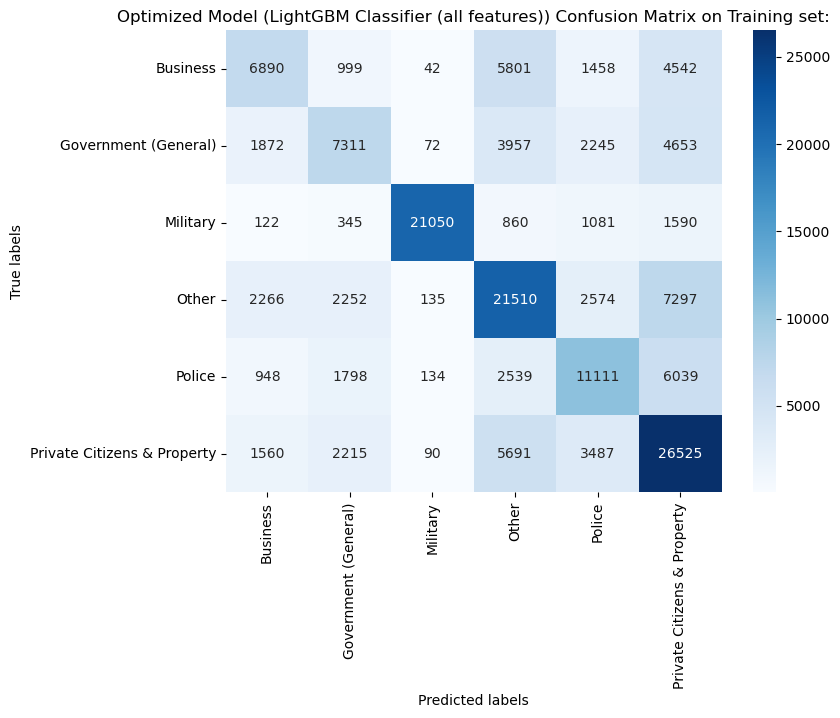

In [21]:

cm = confusion_matrix(y_train_encoded, opt_train_predictions)
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title("Optimized Model ({}) Confusion Matrix on Training set:".format(name))
plt.show()

[[ 301   99    6  674  183 1174]
 [  65 1495   16  503  494 1145]
 [  12   96 7881  204  339  551]
 [ 199  569   42 2250  693 2064]
 [  62  402   78  640 2789 2028]
 [ 123  744   14 1326 1130 9080]]


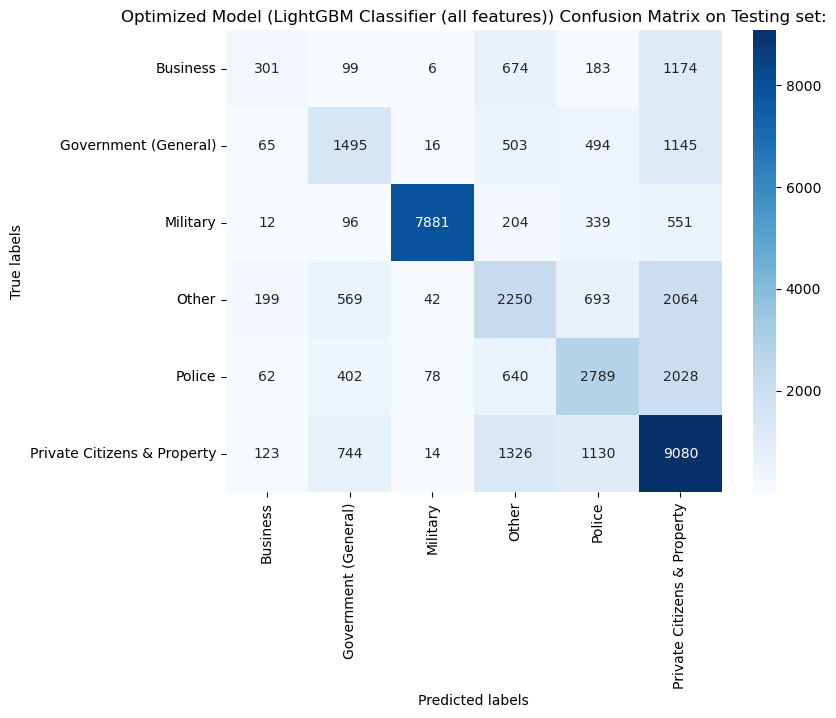

In [22]:

cm = confusion_matrix(y_test_encoded, opt_test_predictions)
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title("Optimized Model ({}) Confusion Matrix on Testing set:".format(name))
plt.show()

In [23]:
train_report = classification_report(y_train_encoded, opt_train_predictions)
print("Optimized Model ({}) Classification Report on Training set:".format(name))
print(train_report)

test_report = classification_report(y_test_encoded, opt_test_predictions)
print("Optimized Model ({}) Classification Report on Testing set:".format(name))
print(test_report)

Optimized Model (LightGBM Classifier (all features)) Classification Report on Training set:
              precision    recall  f1-score   support

           0       0.50      0.35      0.41     19732
           1       0.49      0.36      0.42     20110
           2       0.98      0.84      0.90     25048
           3       0.53      0.60      0.56     36034
           4       0.51      0.49      0.50     22569
           5       0.52      0.67      0.59     39568

    accuracy                           0.58    163061
   macro avg       0.59      0.55      0.56    163061
weighted avg       0.59      0.58      0.58    163061

Optimized Model (LightGBM Classifier (all features)) Classification Report on Testing set:
              precision    recall  f1-score   support

           0       0.40      0.12      0.19      2437
           1       0.44      0.40      0.42      3718
           2       0.98      0.87      0.92      9083
           3       0.40      0.39      0.39      5817
   

## Save Pipeline

In [24]:
filename = name + '.joblib'

dump(pipeline, filename)

['LightGBM Classifier (all features).joblib']

## Feature Importance Analysis

In [25]:
try:
    feature_importances = pipeline.named_steps['classifier'].feature_importances_
    feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

 
    feature_names = [name.split('_', 2)[-1] for name in feature_names]

    sorted_importances = sorted(zip(feature_names, feature_importances), key=lambda x: x[1], reverse=True)

    print("Feature Importances:")
    for feature_name, importance in sorted_importances:
        print(f"{feature_name}: {importance}")
except AttributeError:
  
    raise ValueError("Feature importances are not available for the chosen classifier.")


Feature Importances:
INT_MISC_0: 611
multiple_0: 555
attacktype1_txt_Assassination: 524
city_Other: 507
gname_Unknown: 459
attacktype1_txt_Bombing/Explosion: 377
country_txt_Afghanistan: 357
weapsubtype1_txt_Unknown Explosive Type: 356
attacktype1_txt_Armed Assault: 355
weaptype1_txt_Explosives: 338
iyear_2015: 337
attacktype1_txt_Facility/Infrastructure Attack: 337
weapsubtype1_txt_Projectile (rockets, mortars, RPGs, etc.): 325
region_txt_Western Europe: 319
attacktype1_txt_Hostage Taking (Kidnapping): 301
iyear_2014: 274
region_txt_Middle East & North Africa: 273
crit3_0: 265
weaptype1_txt_Incendiary: 253
country_txt_Iraq: 252
iyear_2016: 249
region_txt_Sub-Saharan Africa: 249
region_txt_South America: 242
country_txt_Pakistan: 238
region_txt_South Asia: 234
iyear_2012: 233
city_Unknown: 232
INT_MISC_1: 229
provstate_northern ireland: 225
iyear_2013: 211
provstate_Other: 208
region_txt_Southeast Asia: 202
weapsubtype1_txt_Landmine: 201
suicide_0: 196
weaptype1_txt_Firearms: 191
weaps

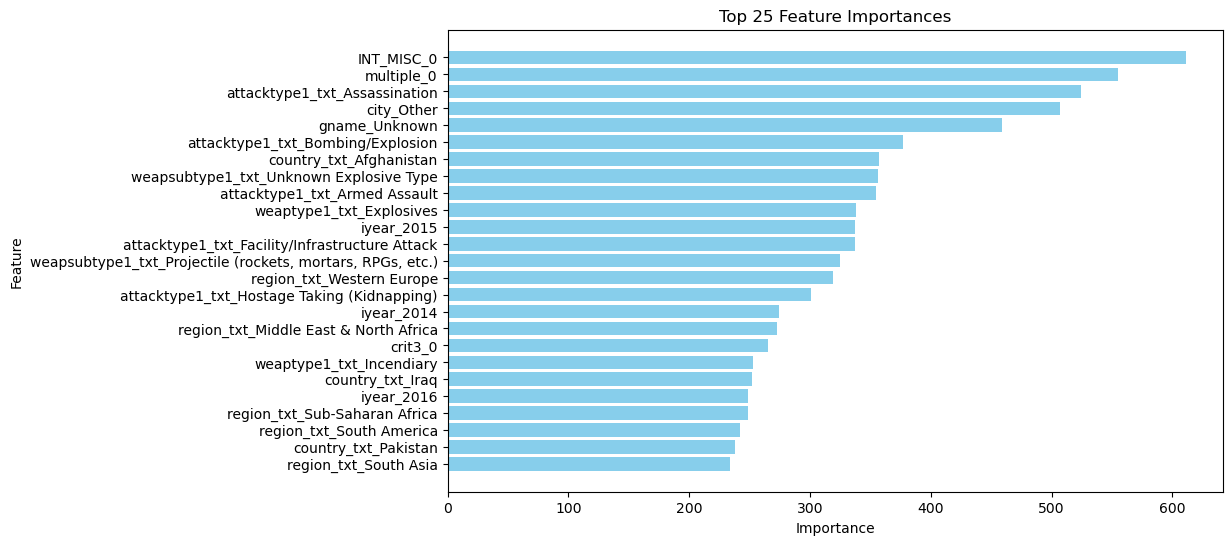

In [26]:

top_features_count = 25


top_features = [feature_name for feature_name, _ in sorted_importances[:top_features_count]]
top_importances = [importance for _, importance in sorted_importances[:top_features_count]]


plt.figure(figsize=(10, 6))
plt.barh(top_features, top_importances, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title(f'Top {top_features_count} Feature Importances')
plt.gca().invert_yaxis()  
plt.show()


## Hyperparameter Graph

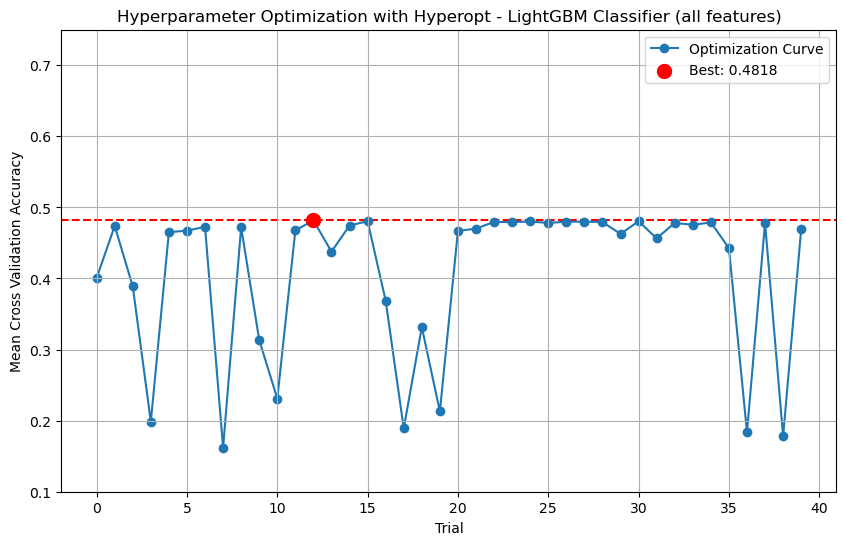

In [27]:
import matplotlib.pyplot as plt


losses = [-trial['result']['loss'] for trial in trials.trials]


plt.figure(figsize=(10, 6))
plt.plot(losses, marker='o', linestyle='-', label='Optimization Curve', zorder=1)  
plt.xlabel('Trial')
plt.ylabel('Mean Cross Validation Accuracy')
plt.title(f'Hyperparameter Optimization with Hyperopt - {name}')
plt.grid(True)


plt.ylim(0.1, 0.75)


best_iteration = len(losses) - 1 - losses[::-1].index(max(losses))  
best_loss = max(losses)


plt.scatter([best_iteration], [best_loss], color='red', label=f'Best: {best_loss:.4f}', s=100, marker='o', zorder=2)  # Higher zorder to plot in front


plt.axhline(y=best_loss, color='red', linestyle='--', zorder=0) 

plt.legend()

plt.show()